# ***Streptomyces*** MLST minimum spanning tree with NetworkX and plotly

**Setp Up - importing python modules/libraries**

In [51]:
import networkx as nx
import pandas as pd
from collections import defaultdict
import plotly.graph_objects as go
import plotly.express as px
import random
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from pathlib import Path
import shutil
import os
import xml.dom.minidom

**Loading data**

1. MLST scheme

In [52]:
df = pd.read_csv(Path("../supplementary_file_8/output/revised_scheme/revised_scheme.txt"),sep='\t', dtype=int)

2. Annotation data. 
Data containing information about each genome and its corresponding sequence type, oranism's name etc.

In [53]:
df2 = pd.read_csv(Path("../supplementary_file_8/output/Genome_ST_info.csv").expanduser())

**Assign each ST profile as an attribute**

This will allow to calculate weights using hamming distance for each edge.

In [74]:
#Making dictionary with a allelic profiles as list keyed by a ST
strep_profiles = df.set_index('ST').T.to_dict('list')
#ADD profiles as a new column to a dataframe
df["profiles"] = df["ST"].map(strep_profiles)
# Creating nested dictionary
attributes = df.set_index('ST')[list(['profiles'])].T.to_dict()

In [75]:

def hamming_dist(profile_1, profile_2):
    """Return distance between two allelic profiles.
    
    Given two profiles (profile_1 and profile_2), 
    the Hamming distance is the number of correspondig loci 
    that differ in profile_1 and profile_2. 
    """
    
    
    hmm = int(sum([profile_1 != profile_2 for profile_1, profile_2 in zip(profile_1, profile_2)]))
    
    return hmm

**Extracting node positions from `xml` file generated by cytoscape**
Once the node positions are fixed in cytoscape, the visualisation can be saved as `.xml` and node positions can be extraced using python module `xml.dom.minidom` module. 

In [76]:
import xml.dom.minidom
file=("../supplementary_file_16/output/mlst_mst_fixed_node_positions.xml")
positions ={}
xmldoc=xml.dom.minidom.parse(file)
STNode = xmldoc.getElementsByTagName('node')
for STChild in STNode:
    ST = STChild.attributes['label'].value
    for parts in STChild.childNodes:
        if parts.nodeType == xml.dom.Node.ELEMENT_NODE: 
            if parts.tagName =='graphics':
                x = float(parts.attributes['x'].value)
                y = float(parts.attributes['y'].value)
                positions[int(ST)] = (x,y)
                

                

In [77]:
edges =[]
xmldoc=xml.dom.minidom.parse(file)
edgesNode = xmldoc.getElementsByTagName('edge')
for _ in edgesNode:
    source = str(_.attributes['label'].value).split(' (-) ')
    edges.append([int(source[0]), int(source[1])])


**Creating a new MST in networkX**

Now having the corrected node positions, we can create new minimum spanning tree.

In [78]:
G = nx.Graph()
pos = nx.spring_layout(G)
for k, v in positions.items():
    G.add_node(k)
    pos[k] = v

In [79]:
new_pos = {}
for k, v in positions.items():
    new_pos[k] = list(v) 

In [80]:
nx.set_node_attributes(G, new_pos, "pos")

Adding edges to our new tree

In [81]:
for _ in edges:
    G.add_edge(_[0], _[1])

No we can assign profiles as attributes to each node

In [82]:
nx.set_node_attributes(G, attributes)

and calculate their weights

In [83]:
for edge in G.edges:
    n1, n2 = edge
    G[n1][n2]["weight"] = hamming_dist(G.nodes[n1]['profiles'], G.nodes[n2]['profiles'])

**Question 1: How many groups of united STs?**
Using `connecte_components` function we can chck how many groups of united STs there are under Hamming distance.

In [84]:
connected_components  = sorted(nx.connected_components(G), key = len, reverse=True)

In [85]:
sizes_of_subgraphs = [len(_) for _ in connected_components]
sizes = pd.DataFrame(sizes_of_subgraphs, columns=['Size'])
sizes.to_csv("subgraph_sizes.csv", index=False)

**Creating interactive networkX minimum spanning tree in plotly**

First we need to add edges as disconnected lines in a single trace and nodes as a scatter trace.

Source code can be found [here](https://plotly.com/python/network-graphs/).

In [86]:
edge_x = []
edge_y = []
edge_weight = []
for edge in G.edges():
    for k, v in positions.items():
        if str(edge[0]) == str(k):
            edge_x.append(v[0])
            edge_y.append(v[1])
            edge_weight.append(str(G[edge[0]][edge[1]]['weight']))
        if str(edge[1]) == str(k):
            edge_x.append(v[0])
            edge_y.append(v[1])
            edge_x.append(None)
            edge_y.append(None)

In [87]:
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

In [88]:
node_x = []
node_y = []
for node in G.nodes():
    for k, v in positions.items():
        if str(node) == str(k):
            node_x.append(v[0])
            node_y.append(v[1])


In [89]:

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=5,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=1))

**Adding annotations to edges**

As `plotly` doe not allow to add hoover text to edges, we can fix this by adding a transparent node in the middle of each edge, and add hoover annotations that way. 

The information that could be useful to view are:

- `hamming distance`
- `sheared markers`

In [90]:
def common_marker(node_1, node_2, path_to_file):
    """Return a list of common markers
    for a given edge.
    
    :param node_1: networkX node 1
    :param node_2: networkX node 2
    :param path_to_file: path to tab separated file with MLST scheme
    """
    df = pd.read_csv(path_to_file,sep='\t', dtype=int)
    common_markers = []
    try:
        for _ in df:
            if _ != 'ST':
                if int(df.loc[df['ST'] == node_1][_]) == int(df.loc[df['ST'] == node_2][_]):
                    common_markers.append(str(_))
    except IndexError:
        print("done")
        
    return common_markers

In [91]:
middle_node_x = []
middle_node_y = []
weights = []
for edges in G.edges():
    edge1_x = G.nodes[edges[0]]['pos'][0]
    edge1_y = G.nodes[edges[0]]['pos'][1]
    edge2_x = G.nodes[edges[1]]['pos'][0]
    edge2_y = G.nodes[edges[1]]['pos'][1]
    new_x_pos = (edge1_x + edge2_x)/2
    new_y_pos = (edge1_y + edge2_y)/2
    middle_node_x.append(new_x_pos)
    middle_node_y.append(new_y_pos)


for edges in G.edges():
    sheared_markers = str(common_marker(edges[0], edges[1], Path("../supplementary_file_8/output/revised_scheme/revised_scheme.txt"))).replace('[', '').replace(']','').replace("'", "").replace(',','')
    weights.append("<b>Hamming Distance: </b>"+str(G[edges[0]][edges[1]]['weight'])+"<br><b>Sheared markers: </b>" + sheared_markers)
            
middle_node_trace = go.Scatter(
    x=middle_node_x, y=middle_node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=5,
        opacity=0,
        line_width=1))
middle_node_trace['text'] = weights

**Create hoover text**

1. We need to create a dictionary with ST as key, and degree as values, and add this to our dataframe. The needed information can be then pulled from the table.

In [94]:
degree = {}
for node, adjacencies in enumerate(G.adjacency()):
    degree[adjacencies[0]] = len(adjacencies[1])
    
df2["degree"] = df2["ST"].map(degree)


In [96]:
df2.to_csv("Genome_ST_info.csv", index=False)

In [98]:
# Convert dictionary to DataFrame
degrees_data = pd.DataFrame(list(degree.items()), columns=['ST', 'Degree'])

# Display the DataFrame
print(degrees_data)

# Optionally, save the DataFrame to a file
# Save to CSV
degrees_data.to_csv('ST_degrees.csv', index=False)

      ST  Degree
0      1       2
1      2       6
2      3       9
3      4       2
4      5       7
..   ...     ...
800  801       0
801  802       1
802  803       0
803  804       1
804  805       2

[805 rows x 2 columns]


**pyani species_id**

We have carried out pyani analysis based on each connected component. We can add this informtaon to hoover text in the following steps:


In [28]:
df2 = pd.read_csv(Path("../supplementary_file_8/output/Genome_ST_info.csv").expanduser())

In [29]:
df2['accession'] = df2['accession']

In [30]:
current_genomes = [_ for _ in df2['accession']]

In [31]:
new_labels = df2.set_index('accession').to_dict()['pyani_label']

2. we need to identify how many species accoridng to pyani analysis there are per each ST.

In [32]:
def get_species_per_st(row):
    """Return a dictionary with ST as key, 
    and genomespecies_id as value.
    """
    
    try:
        row_dict = {}
        key = row['pyani_label'].split(' ')[-1]
        value = row['pyani_species_ID']
        row_dict[key] = value
    except IndexError:
        row_dict = 'NA'

    return row_dict

species_per_st = df2.apply(get_species_per_st, axis=1)

#Hold an empty delfautdict that we can the used to append information
all_species_per_st = defaultdict(list)
for k, v in species_per_st.items():
    for k1, v1 in v.items():
        all_species_per_st[int(k1)].append(v1)

Check if there is only one unqque species id per ST

In [33]:
for k, v in all_species_per_st.items():
    if len(set(v)) != 1:
        print(k, v)

As there is no STs that would represent multiple species according to pyani analysis, we can create a dictionary with ST as a key and the assiged species id as a value.

In [34]:
species_id_per_st = {}
for k, v in all_species_per_st.items():
    if len(set(v)) ==1:
        species_id_per_st[k] = str(set(v)).replace("{", "").replace("}", "")

Now we can extend our dictionary with STs that are not represneted in GenBank. This is necesssary to add this information to node attributes in order to annotate the tree. 


In [35]:
pubMLST_STs = [_ for _ in range(1, 238)]
represented_STs = list(set([int(_) for _ in df2['ST']]))
STs_not_represented = [pubmlst_st for pubmlst_st in pubMLST_STs if int(pubmlst_st) not in represented_STs]

In [36]:

for _ in STs_not_represented:
    species_id_per_st[_] = "no_pyani_results"

Now we can assign the species_id to each node as an attibute

In [37]:
nx.set_node_attributes(G, species_id_per_st, "pyani_species_id")

**pyani genus_id**

1. We need to check how many genra there is per ST

In [38]:
def get_genus_per_st(row):
    """Return a dictionary with ST as key, 
    and genomespecies_id as value.
    """
    
    try:
        row_dict = {}
        key = row['pyani_label'].split(' ')[-1]
        value = row['pyani_genus_ID']
        row_dict[key] = value
    except IndexError:
        row_dict = 'NA'

    return row_dict

genus_per_st = df2.apply(get_genus_per_st, axis=1)

#Hold an empty delfautdict that we can the used to append information
all_genus_per_st = defaultdict(list)
for k, v in genus_per_st.items():
    for k1, v1 in v.items():
        all_genus_per_st[int(k1)].append(v1)

2. We need to check if there is only one genus per ST. 
We know that here is only 1 unique species per ST. However, this step is essneital to double check that there is no bug in our data.

In [39]:
for k, v in all_genus_per_st.items():
    if len(set(v)) != 1:
        print(k)

As there is no STs that would represent multiple genra according to pyani analysis, we can create a dictionary with ST as a key and the assiged genus id as a value

In [40]:
genus_id_per_st = {}
for k, v in all_genus_per_st.items():
    if len(set(v)) ==1:
        genus_id_per_st[k] = str(set(v)).replace("{", "").replace("}", "")

Now we can extend our dictionary with STs that are not represneted in GenBank. This is necesssary to add this information to node attributes in order to annotate the tree. 

In [41]:
for _ in STs_not_represented:
    genus_id_per_st[_] = "no_pyani_results"

Now we can add this information to each node as an attibute

In [42]:
nx.set_node_attributes(G, genus_id_per_st, "pyani_genus_id")

In [43]:
df2 = df2.astype({"16S_copies": str, "pyani_group_ID": str, "pyani_genus_ID": str, "strain":  str})

In [44]:
def genome_entry_information_to_dict(row):
    """Return a dictionary with each all genome's information,
    keyed by ST for each row.

    """

    try:
        row_dict = {}
        key = row['ST']
        value = '<b><br>Genome accession: </b>' +str(row['accession'])+ '<b><br>Species: </b>' + str(row['organism']) + '<b><br>Strain: </b>' +row['strain'] + '<b><br>16S rRNA copies: </b>' + str(row['16S_copies']) + '<b><br>Type strain: </b>' + str(row['Type_Strain']) + '<b><br>Taxonomy status: </b>'+ str(row['status_tax']) + '</b><br><br>'
        row_dict[key] = value
    except IndexError:
        row_dict = 'NA'

    return row_dict
    

st_info = df2.apply(genome_entry_information_to_dict, axis=1)


#Create a dictionary with ALL organism names as a value, keyed by ST
all_info_per_st = defaultdict(list)

for k, v in st_info.items():
    for k1, v1 in v.items():
        all_info_per_st[int(k1)].append(v1)
#Edit labels in a way you want them appear in plotly

#Adding degree information

plotly_labels = {}
for k, v in all_info_per_st.items():
    for k1, v1 in degree.items():
        if k == int(k1):
            label = '<br><b>Degree: </b>' +str(v1) +"<br>" + str(v).replace("['", '').replace("']", "").replace(',','').replace("'", "")
            plotly_labels[k] = label

pubMLST_STs = [_ for _ in range(1, 237)]
represented_STs = [k for k, v in plotly_labels.items()]
STs_not_represented = [pubmlst_st for pubmlst_st in pubMLST_STs if pubmlst_st not in represented_STs]

            
#Adding pyani genus id
for st, label in plotly_labels.items():
    for st2, genus_id in genus_id_per_st.items():
        if st == st2:
            new_label = '<br><b>Pyani genus id: </b>' + str(genus_id) + label
            plotly_labels[st] = new_label
            
            

#Adding pyani species id and ST
for st, label in plotly_labels.items():
    for st2, species_id in species_id_per_st.items():
        if st == st2:
            new_label = '<b>ST '+str(st)+"</b>" + '<br><b>Pyani species id: </b>' + str(species_id) + label
            plotly_labels[st] = new_label

            
            
counter = 0
for _ in STs_not_represented:
    for k, v in degree.items():
        if str(k) == str(_):
            missing_label = "ST " + str(_) + " not represented in GenBank" +"<br><b>Degree: </b>"+ str(v)
            plotly_labels[int(_)] = missing_label

    
#ADD profiles as a new column to a dataframe
df["plotly_labels"] = df["ST"].map(plotly_labels)

df = df.fillna("ST not represented in Genbank")

# Creating nested dictionary
labels = df.set_index('ST')[list(['plotly_labels'])].T.to_dict()


#Add as a node attribute
nx.set_node_attributes(G, labels)


node_text = []
for node in G.nodes():
    node_text.append(str(G.nodes[node]['plotly_labels']) + '<br><br>')
    
node_trace.text = node_text

**Colour Node Points**
Color node positions by the number of connections.

In [102]:
node_adjacencies = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    

node_trace.marker.color = node_adjacencies

**Create Netwok Graph - Node connections**

In [103]:
fig = go.Figure(data=[edge_trace, node_trace] + [ middle_node_trace],
             layout=go.Layout(
                title='',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                hoverlabel=dict(font_size=10),

                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.update_layout(
    plot_bgcolor='white')
fig.show()
fig.write_html(Path("../supplementary_file_23.html").expanduser())
fig.write_image(Path("../supplementary_file_23.pdf").expanduser())


In [106]:
# Extract the colors from node_trace
node_colors = node_trace.marker.color
print("Node colors:", node_colors)

Node colors: (2, 6, 9, 2, 7, 2, 2, 13, 2, 1, 0, 3, 6, 6, 0, 0, 3, 3, 2, 1, 1, 1, 5, 5, 0, 1, 2, 2, 1, 0, 3, 0, 0, 0, 0, 3, 3, 1, 3, 2, 2, 3, 2, 1, 4, 1, 1, 1, 3, 0, 1, 0, 1, 1, 1, 2, 4, 4, 1, 1, 5, 1, 5, 4, 0, 0, 2, 0, 0, 2, 1, 1, 0, 1, 2, 0, 2, 4, 1, 3, 2, 1, 0, 0, 1, 2, 2, 1, 1, 0, 1, 2, 2, 4, 2, 1, 2, 4, 1, 2, 2, 1, 0, 0, 10, 4, 5, 4, 1, 1, 1, 6, 4, 2, 4, 3, 0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 2, 1, 2, 1, 4, 4, 1, 1, 1, 0, 1, 2, 3, 2, 3, 4, 2, 1, 1, 1, 2, 1, 3, 1, 1, 2, 2, 1, 1, 3, 1, 0, 0, 0, 2, 0, 2, 0, 1, 1, 0, 3, 0, 0, 0, 2, 0, 1, 2, 3, 1, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 1, 1, 4, 4, 1, 2, 0, 0, 1, 1, 0, 2, 1, 4, 1, 2, 2, 1, 1, 3, 1, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 4, 2, 0, 4, 1, 2, 1, 1, 3, 2, 2, 0, 1, 1, 3, 3, 1, 0, 4, 2, 3, 2, 0, 2, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 6, 1, 0, 2, 2, 1, 0, 0, 1, 2, 0, 0, 1, 3, 0, 2, 1, 1, 1, 0, 0, 4, 1, 2, 1, 2, 0, 2, 1, 0, 0, 3, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 2, 1, 5, 0, 

In [105]:
node_colors

(2,
 6,
 9,
 2,
 7,
 2,
 2,
 13,
 2,
 1,
 0,
 3,
 6,
 6,
 0,
 0,
 3,
 3,
 2,
 1,
 1,
 1,
 5,
 5,
 0,
 1,
 2,
 2,
 1,
 0,
 3,
 0,
 0,
 0,
 0,
 3,
 3,
 1,
 3,
 2,
 2,
 3,
 2,
 1,
 4,
 1,
 1,
 1,
 3,
 0,
 1,
 0,
 1,
 1,
 1,
 2,
 4,
 4,
 1,
 1,
 5,
 1,
 5,
 4,
 0,
 0,
 2,
 0,
 0,
 2,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 4,
 1,
 3,
 2,
 1,
 0,
 0,
 1,
 2,
 2,
 1,
 1,
 0,
 1,
 2,
 2,
 4,
 2,
 1,
 2,
 4,
 1,
 2,
 2,
 1,
 0,
 0,
 10,
 4,
 5,
 4,
 1,
 1,
 1,
 6,
 4,
 2,
 4,
 3,
 0,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 0,
 1,
 2,
 1,
 2,
 1,
 4,
 4,
 1,
 1,
 1,
 0,
 1,
 2,
 3,
 2,
 3,
 4,
 2,
 1,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 2,
 1,
 1,
 3,
 1,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 1,
 1,
 0,
 3,
 0,
 0,
 0,
 2,
 0,
 1,
 2,
 3,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 4,
 4,
 1,
 2,
 0,
 0,
 1,
 1,
 0,
 2,
 1,
 4,
 1,
 2,
 2,
 1,
 1,
 3,
 1,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 4,
 2,
 0,
 4,
 1,
 2,
 1,
 1,
 3,
 2,
 2

**Create Network Graph - Streptomyces sequence type representation in GenBank**

In [41]:
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=5,
        line_width=1))

In [42]:
node_colours = []
for node in G.nodes():
    if 'not represented' in G.nodes[node]['plotly_labels']:
        node_colours.append("rgb(59,82,139)")
    else:
        node_colours.append("rgb(94,201,98)")

node_trace.marker.color = node_colours

In [43]:
node_trace.text = node_text

In [44]:
fig = go.Figure(data=[edge_trace, node_trace] + [middle_node_trace],
             layout=go.Layout(
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                hoverlabel=dict(font_size=10),

                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
               )



fig.add_shape(type="rect",
    line_width=1,
    line=dict(
    color="Red",
    width=2,
    ),
    xref="x domain", yref="y domain",
    x0=0.96, x1=0.86, y0=0.43, y1=0.55,
    layer='below'
)

fig.show()
fig.update_layout(
    plot_bgcolor='white')



fig.write_html(Path("../supplementary_file_24.html").expanduser())
fig.write_image(Path("../supplementary_file_24.pdf").expanduser())




**Create Netwrok Graph - pubMLST St vs New**

In [45]:
node_colours = []
for node in G.nodes():
    if node >= 237:
        node_colours.append("rgb(59,82,139)")
    else:
        node_colours.append("rgb(94,201,98)")

node_trace.marker.color = node_colours

In [46]:
fig = go.Figure(data=[edge_trace, node_trace] + [middle_node_trace],
             layout=go.Layout(
#                 title='<br><b>pubMLST vs new <i>Streptomyces</i> sequence types</b>',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                hoverlabel=dict(font_size=10),

                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )


fig.update_layout(
    plot_bgcolor='white')
fig.write_html(Path("../supplementary_file_25.html").expanduser())



fig.add_shape(type="rect",
    line_width=1,
    line=dict(
    color="Red",
    width=2,
    ),
    xref="x domain", yref="y domain",
    x0=0.96, x1=0.86, y0=0.43, y1=0.55,
    layer='below'
)

fig.add_shape(type="rect",
    line_width=1,
    line=dict(
    color="cornflowerblue",
    width=2,
    ),
    xref="x domain", yref="y domain",
    x0=0.12, x1=0.18, y0=0.74, y1=0.63,
    layer='below'
)

fig.add_shape(type="rect",
    line_width=1,
    line=dict(
    color="darkgreen",
    width=2,
    ),
    xref="x domain", yref="y domain",
    x0=0.305, x1=0.04, y0=0.40, y1=0.048,
    layer='below'
)

fig.show()


fig.write_image(Path("main_text_figures/MST_00001.pdf").expanduser())


**Create Network Graph - pyani type genomes**

We have manualy identified type genomes by looking at pyani analysis. We can use this information to colour code nodes witin each connected components to see how diffrent species appear in the network.

As we already assigned pyani_species_id to each node attibute and we have a a dictionary with ST as key and their assigned species id as values, we can no do:
- can create a dictionary with a pyani component number(arbitary) and a list of all species ids (given after pyani analysis)

In [47]:
pyani_species_per_component = defaultdict(list)
for nodes in enumerate(nx.connected_components(G)):
    for node in nodes[1]:
        pyani_species_per_component[nodes[0]].append(G.nodes[node]['pyani_species_id'])
    

Now we can get a dictionary that will only contain a set of unique species ids, rather than all instances

In [48]:
comp_set = {k:list(set(sorted(v))) for k, v in pyani_species_per_component.items()}


We can now assign a colour to each species ids within each component.
And create a dictionary keyed by the species ID, with values of a given colour. Node that STs that are not represented in Genbank are excluded at this point.

In [49]:

colour_per_species = {}
for k, v in comp_set.items():
    if 'no_pyani_results' in v:
        v.remove('no_pyani_results')
        palette = sns.color_palette("Spectral", len(v))
        palette=palette.as_hex()
        colour_per_species.update(dict(zip(v,palette)))
    else:
        palette = sns.color_palette("Spectral", len(v))
        palette=palette.as_hex()
        colour_per_species.update(dict(zip(v,palette)))
          
    

Now we can add anoter item to our dictionary, and add a grey colour. 
This will be used for nodes where teher is no representation in GenBank

In [50]:
colour_per_species['no_pyani_results'] = '#808080'

Now we can generate a graph

In [51]:
node_colours = []
for node in G.nodes():
    for k, v in colour_per_species.items():
        if k == G.nodes[node]['pyani_species_id']:
            node_colours.append(v)
node_trace.marker.color = node_colours    


In [54]:
fig = go.Figure(data=[edge_trace, node_trace] + [ middle_node_trace],
             layout=go.Layout(
#                 title='<br><b>Unique species according to pyANI analysis within each connected component</b>',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                hoverlabel=dict(font_size=10),

                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.update_layout(
    plot_bgcolor='white')

fig.add_shape(type="rect",
    line_width=1,
    line=dict(
    color="red",
    width=2,
    ),
    xref="x domain", yref="y domain",
    x0=0.305, x1=0.04, y0=0.40, y1=0.048,
    layer='below'
)

fig.show()

fig.write_html(Path("../supplementary_file_27.html").expanduser())
fig.write_image(Path("../supplementary_file_27.pdf").expanduser())


**Create network graph - unique genra - pyani analysis**

We have run pyani analysis on each connected component. 
From literature we know that when genomes share at least 50% ANI coverage, these can be considered to belong to the same genra. 


Now we can create a dictionary with a pyani component number(arbitary) and a list of all genus ids (given after pyani analysis)


In [55]:

pyani_genus_per_component = defaultdict(list)
for nodes in enumerate(nx.connected_components(G)):
    for node in nodes[1]:
        pyani_genus_per_component[nodes[0]].append(G.nodes[node]['pyani_genus_id'])

Now we can create a dictionary that will only contain a set of unique gensus per component

In [56]:
comp_set_genus = {k:list(set(sorted(v))) for k, v in pyani_genus_per_component.items()}

We can now assign a colour to each genus ids within each component.
And create a dictionary keyed by the species ID, with values of a given colour. Node that STs that are not represented in Genbank are excluded at this point.


In [57]:
colour_per_genus = {}
for k, v in comp_set_genus.items():
    if 'no_pyani_results' in v:
        v.remove('no_pyani_results')
        palette = sns.color_palette("Spectral", len(v))
        palette=palette.as_hex()
        colour_per_genus.update(dict(zip(v,palette)))
    else:
        palette = sns.color_palette("Spectral", len(v))
        palette=palette.as_hex()
        colour_per_genus.update(dict(zip(v,palette)))

Now we can add anoter item to our dictionary with agrey colour for nodes where the is no genbank representation

In [58]:
colour_per_genus['no_pyani_results'] = '#808080'

We can now create our MST

In [59]:
node_colours = []
for node in G.nodes():
    for k, v in colour_per_genus.items():
        if k == G.nodes[node]['pyani_genus_id']:
            node_colours.append(v)
node_trace.marker.color = node_colours    

In [66]:
fig = go.Figure(data=[edge_trace, node_trace] + [ middle_node_trace],
             layout=go.Layout(
#                 title='<br><b>Unique genera according to pyANI analysis within each connected component</b>',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                hoverlabel=dict(font_size=10),

                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )


fig.add_shape(type="rect",
    line_width=1,
    line=dict(
    color="darkgreen",
    width=2,
    ),
    xref="x domain", yref="y domain",
    x0=0.305, x1=0.58, y0=0.40, y1=0.048,
    layer='below'
)

fig.update_layout(
    plot_bgcolor='white')


fig.show()
fig.write_html(Path("../supplementary_file_26.html").expanduser())
fig.write_image(Path("../supplementary_file_26.pdf").expanduser())

**Create simplifies verion of the graphs for the manuscript**

Here, we will remove nodes/connected components consisting of a single genus/species. 

In [63]:
species_per_ST = df2.set_index('ST').to_dict()['pyani_species_ID']

In [64]:
def get_pyani_taxa_ID(STs, IDs):
    """Return a list of assigned taxaIDs
    for a given list of STs.
    
    
    """
    taxa = []
    
    try:
        for _ in STs:
            if _ in IDs.keys():
                taxa.append(IDs[_])
    except KeyError:
        x = taxa.append('NA')
    
    
    return taxa

In [65]:
to_remove = []

for cc in connected_components:
    taxa = get_pyani_taxa_ID(list(cc), species_per_ST)
    if len(set(taxa)) <= 1:
        to_remove.extend(list(cc))

In [66]:
distinct_genus_tree = G
distinct_genus_tree.remove_nodes_from(to_remove)


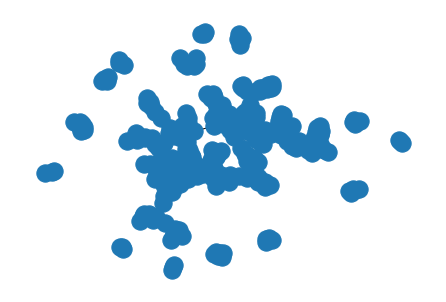

In [67]:
nx.draw(distinct_genus_tree)

In [68]:
print(distinct_genus_tree)

Graph with 321 nodes and 299 edges


Now, we will save the tree as graphml, fix the position of the nodes in cytoscape, and generate figures. 

In [69]:
for node in distinct_genus_tree:
    del distinct_genus_tree.nodes[node]['profiles']
    del distinct_genus_tree.nodes[node]['pos']

In [70]:
nx.write_graphml_lxml(distinct_genus_tree, Path("../supplementary_file_16/output/mlst_mst_simplified.graphml").expanduser())

After fixingthe position of the nodes in Cytoscape, we can now generate graphics for the MS.

In [67]:
import xml.dom.minidom
file=("../supplementary_file_16/output/mlst_mst_simplified_fixed_positions.xml")
positions ={}
xmldoc=xml.dom.minidom.parse(file)
STNode = xmldoc.getElementsByTagName('node')
for STChild in STNode:
    ST = STChild.attributes['label'].value
    for parts in STChild.childNodes:
        if parts.nodeType == xml.dom.Node.ELEMENT_NODE: 
            if parts.tagName =='graphics':
                x = float(parts.attributes['x'].value)
                y = float(parts.attributes['y'].value)
                positions[int(ST)] = (x,y)
                

In [68]:
edges =[]
xmldoc=xml.dom.minidom.parse(file)
edgesNode = xmldoc.getElementsByTagName('edge')
for _ in edgesNode:
    source = str(_.attributes['label'].value).split(' (-) ')
    edges.append([int(source[0]), int(source[1])])

nx.set_node_attributes(G, attributes)

Here, we create a new graph with fixed position of the nodes

In [69]:
G = nx.Graph()
pos = nx.spring_layout(G)
for k, v in positions.items():
    G.add_node(k)
    pos[k] = v
new_pos = {}
for k, v in positions.items():
    new_pos[k] = list(v) 
nx.set_node_attributes(G, new_pos, "pos")

Here, we are adding new edges to the graph and caulcate thier weights

In [70]:
for _ in edges:
    G.add_edge(_[0], _[1])

In [71]:
nx.set_node_attributes(G, attributes)
for edge in G.edges:
    n1, n2 = edge
    G[n1][n2]["weight"] = hamming_dist(G.nodes[n1]['profiles'], G.nodes[n2]['profiles'])

Creating network in plotly

In [72]:
edge_x = []
edge_y = []
edge_weight = []
for edge in G.edges():
    for k, v in positions.items():
        if str(edge[0]) == str(k):
            edge_x.append(v[0])
            edge_y.append(v[1])
            edge_weight.append(str(G[edge[0]][edge[1]]['weight']))
        if str(edge[1]) == str(k):
            edge_x.append(v[0])
            edge_y.append(v[1])
            edge_x.append(None)
            edge_y.append(None)

In [73]:
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

In [74]:
node_x = []
node_y = []
for node in G.nodes():
    for k, v in positions.items():
        if str(node) == str(k):
            node_x.append(v[0])
            node_y.append(v[1])

In [75]:

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        reversescale=False,
        color=[],
        size=5,
        colorbar=dict(
            thickness=15
        ),
        line_width=1))

Colour nodes based on species ID

In [76]:
nx.set_node_attributes(G, labels)

In [77]:
nx.set_node_attributes(G, species_id_per_st, "pyani_species_id")

In [78]:
nx.set_node_attributes(G, genus_id_per_st, "pyani_genus_id")

In [79]:
pyani_species_per_component = defaultdict(list)
for nodes in enumerate(nx.connected_components(G)):
    for node in nodes[1]:
        pyani_species_per_component[nodes[0]].append(G.nodes[node]['pyani_species_id'])

In [80]:

colour_per_species = {}
for k, v in comp_set.items():
    if 'no_pyani_results' in v:
        v.remove('no_pyani_results')
        palette = sns.color_palette("Spectral", len(v))
        palette=palette.as_hex()
        colour_per_species.update(dict(zip(v,palette)))
    else:
        palette = sns.color_palette("Spectral", len(v))
        palette=palette.as_hex()
        colour_per_species.update(dict(zip(v,palette)))

In [81]:
colour_per_species['no_pyani_results'] = '#808080'

In [82]:
node_colours = []
for node in G.nodes():
    for k, v in colour_per_species.items():
        if k == G.nodes[node]['pyani_species_id']:
            node_colours.append(v)
node_trace.marker.color = node_colours    

In [84]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
#                 title='<br><b>Unique species according to pyANI analysis within each connected component</b>',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=0,l=0,r=0,t=0),
                hoverlabel=dict(font_size=10),
                 
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.update_layout(
    plot_bgcolor='white')
fig.update_layout(showlegend=False)

fig.add_shape(type="rect",
    fillcolor="white",
    line_width=1,
    xref="x domain", yref="y domain",
    line_color="red",
    x0=0.04, x1=0.365, y0=0.05, y1=0.5,
    layer='below'
)


fig.show()
fig.write_image(Path("main_text_figures/MST_00004.2.pdf").expanduser())

Now we create simplified version of the graph showing unique genus per connected component

In [85]:
pyani_genus_per_component = defaultdict(list)
for nodes in enumerate(nx.connected_components(G)):
    for node in nodes[1]:
        pyani_genus_per_component[nodes[0]].append(G.nodes[node]['pyani_genus_id'])

In [86]:
comp_set = {k:list(set(sorted(v))) for k, v in pyani_genus_per_component.items()}

In [87]:

colour_per_genus = {}
for k, v in comp_set.items():
    if 'no_pyani_results' in v:
        v.remove('no_pyani_results')
        palette = sns.color_palette("Spectral", len(v))
        palette=palette.as_hex()
        colour_per_genus.update(dict(zip(v,palette)))
    else:
        palette = sns.color_palette("Spectral", len(v))
        palette=palette.as_hex()
        colour_per_genus.update(dict(zip(v,palette)))

In [88]:
colour_per_genus['no_pyani_results'] = '#808080'

In [89]:
node_colours = []
for node in G.nodes():
    for k, v in colour_per_genus.items():
        if k == G.nodes[node]['pyani_genus_id']:
            node_colours.append(v)
node_trace.marker.color = node_colours    

In [95]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
#                 title='<br><b>Unique species according to pyANI analysis within each connected component</b>',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=0,l=0,r=0,t=0),
                hoverlabel=dict(font_size=10),
                 
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, range=[-1700,700]))
                )
fig.update_layout(
    plot_bgcolor='white')
fig.update_layout(showlegend=False)

fig.add_shape(type="rect",
    fillcolor="white",
    line_width=1,
    xref="x domain", yref="y domain",
    line_color="green",
    x0=0.70, x1=0.36, y0=0.01, y1=0.97,
    layer='below'
)


fig.show()
fig.write_image(Path("main_text_figures/MST_00004.3.pdf").expanduser(),width=800, height=300)